# Image2StyleGAN Reproduction

## Checking the pretrained model
    
We will load the necessary libraries to run the pretrained version

In [8]:
# First set the base dir
%cd /scratch
!ls
!ls stuff/pretrained_models/

/scratch
Dockerfile  dnnlib	   environment.yml  notebooks  test.py	    train.py
backup.py   docker_run.sh  model	    stuff      torch_utils  utils
ffhq.pkl


In [43]:
# Import the needed libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch
from torchvision import models, transforms
import torch.optim as optim
from PIL import Image
import os
from torchvision.utils import save_image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [112]:
# Setting global attributes
RESOLUTION = 1024
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

ITERATIONS = 500

# OPTIMIZER
LEARNING_RATE = 0.01
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-8

# GENERATOR
G_LAYERS = 18
Z_SIZE = 512

# IMAGE TO EMBED
PATH_IMAGE = "stuff/data/obama.png"
SAVING_DIR = 'stuff/results/synthetic_images/'

## Loadding Pretrained Model
Load the pretrained model using the pickle file. I need the libraries `dnnlib` and `torch_utils` to load this model.

It does not need source code for the networks themselves — their class definitions are loaded from the pickle via `torch_utils.persistence`.


In [11]:
PRETRAINED_MODEL = "stuff/pretrained_models/ffhq.pkl"

with open(PRETRAINED_MODEL, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
# z = torch.randn([1, G.z_dim]).cuda()    # latent codes
# c = None                                # class labels(not used in this example)
# img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
# print(img)
#print(G)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


The pickle contains three networks. `'G'` and `'D'` are instantaneous snapshots taken during training, and `'G_ema'` represents a moving average of the generator weights over several training steps. The networks are regular instances of `torch.nn.Module`, with all of their parameters and buffers placed on the CPU at import and gradient computation disabled by default.

The generator consists of two submodules, `G.mapping` and `G.synthesis`, that can be executed separately. They also support various additional options:

```.python
w = G.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = G.synthesis(w, noise_mode='const', force_fp32=True)
```

Please refer to [`generate.py`](./generate.py), [`style_mixing.py`](./style_mixing.py), and [`projector.py`](./projector.py) for further examples.

From G we need to extract the `mapping` and the `synthesis` modules.

## Loss Function

The embedding algorithm selects a random initial latent code and optimize it using gradient descent. To do that, the authors defines a loss function based on VGG-16 perceptual loss and the pixel-wise MSE loss:

$$ w^{*}=\min _{w} L_{\text {percept }}(G(w), I)+\frac{\lambda_{m s e}}{N}\|G(w)-I\|_{2}^{2} $$

### VGG-16 perceptual loss
For the perceptual loss term $L_{\text {percept }}(\cdot)$

$$ L_{\text {percept }}\left(I_{1}, I_{2}\right)=\sum_{j=1}^{4} \frac{\lambda_{j}}{N_{j}}\left\|F_{j}\left(I_{1}\right)-F_{j}\left(I_{2}\right)\right\|_{2}^{2} $$

where $I_{1}, I_{2} \in \mathbb{R}^{n \times n \times 3}$ are the input images, $F_j$ is the feature output of VGG-16 layer `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively, $N_j$ is the number of scalars in the $j^{th}$ layer output, $\lambda_j = 1$ for all js are empiracally obtained for good performance.

In [31]:
# First explored the vgg16 module to check the convolutional layers
models.vgg16(pretrained=True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

We need to extract the feature maps after convolutional layers `conv1_1`, `conv1_2`, `conv3_2` and `conv4_2` respectively. 

* `conv1_1` : block 1 - convolution 1
* `conv1_2` : block 1 - convolution 2
* `conv3_2` : block 3 - convolution 2
* `conv4_2` : block 4 - convolution 2

In the previous pytorch module, these convolutional layers corresponds to indexes: 0 2 12 19, but we need to include the ReLu activation and all the previous layers. In this way, we have:

| indexes of layers | number of layers |
|:-----------------:|:----------------:|
|       [0,1]       |         2        |
|       [0,3]       |         4        |
|       [0,13]      |        14        |
|       [0,20]      |        21        |

Then we define a module that extract the respective feature maps:

In [32]:
# Defining the VGG16 Perceptual Network

class PerceptualVGG16(torch.nn.Module):
    def __init__(self, requires_grad=False, n_layers=[2, 4, 14, 21]):
        super(PerceptualVGG16, self).__init__()
        
        # Dowsampling according to input of ImageNet 256x256
        self.upsample2d = torch.nn.Upsample(scale_factor=256/RESOLUTION, mode='bilinear')

        # Get the pretrained vgg16 model
        vgg_pretrained_features = models.vgg16(pretrained=True).features

        self.slice0 = torch.nn.Sequential()
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        
        # [0,1] layers indexes
        for x in range(n_layers[0]):  
            self.slice0.add_module(str(x), vgg_pretrained_features[x])\
            
        # [2, 3] layers indexes
        for x in range(n_layers[0], n_layers[1]):  # relu1_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        
        # [4, 13] layers indexes
        for x in range(n_layers[1], n_layers[2]): # relu3_2
            self.slice2.add_module(str(x), vgg_pretrained_features[x])

        # [14, 20] layers indexes
        for x in range(n_layers[2], n_layers[3]):# relu4_2
            self.slice3.add_module(str(x), vgg_pretrained_features[x])

        # Setting the gradients to false
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad=False
                
    def forward(self, x):
        upsample = self.upsample2d(x)
        
        h0 = self.slice0(upsample)
        h1 = self.slice1(h0)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)

        return h0, h1, h2, h3

Now we define our loss functions, and the function that will measure the loss

In [33]:
# Pixel-Wise MSE Loss
MSE_Loss = nn.MSELoss(reduction="mean")

# VGG-16 perceptual loss
perceptual_net = PerceptualVGG16(n_layers=[2,4,14,21]).to(DEVICE)

In [34]:
def calculate_loss(synth_img,original_img,perceptual_net,MSE_Loss):
    # calculate MSE Loss
    # (lamda_mse/N)*||G(w)-I||^2
    mse_loss = MSE_Loss(synth_img,original_img) 

    # calculate Perceptual Loss
    # sum_all (lamda_j / N) * ||F(I1) - F(I2)||^2
    real_0,real_1,real_2,real_3 = perceptual_net(original_img)
    synth_0,synth_1,synth_2,synth_3=perceptual_net(synth_img)

    perceptual_loss=0
    perceptual_loss+=MSE_Loss(synth_0,real_0)
    perceptual_loss+=MSE_Loss(synth_1,real_1)
    perceptual_loss+=MSE_Loss(synth_2,real_2)
    perceptual_loss+=MSE_Loss(synth_3,real_3)

    return mse_loss,perceptual_loss

## Embedding Latent and Optimizer Adam

In the article, the authors mention that they select a random initial latent code and optimize it using gradient descent. In this way, I define our tensor `embedding_latent` with gradients.

Then, I define the adam optimizer with the specification of the paper.

In [115]:
# the embeding latent contains the style latents (each one with a size of 512) of the 18 layers in the generator.
embedding_latent = torch.zeros((1,18,512),requires_grad=True,device=DEVICE)
optimizer = optim.Adam({embedding_latent},lr=LEARNING_RATE,betas=(BETA_1,BETA_2),eps=EPSILON)

## Preparing Data

Should I peform any preproccesing to the the images according to the paper?

In [116]:
def image_reader(img_path,resize=None):

    with open(img_path,"rb") as f:
        image=Image.open(f)
        image=image.convert("RGB")
    if resize is not None:
        image=image.resize((resize,resize))
    transform = transforms.Compose([
    transforms.ToTensor()
    ])

    image = transform(image)


    image=image.unsqueeze(0)

    return image

torch.Size([1, 3, 1024, 1024])
tensor(0.9961, device='cuda:0')
tensor(0., device='cuda:0')
obama


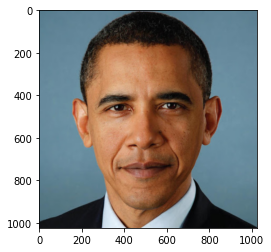

In [120]:
img=image_reader(PATH_IMAGE,resize=RESOLUTION)
img=img.to(DEVICE)
basename=os.path.basename(os.path.normpath(PATH_IMAGE)).split(".")[0]
print(img.size())
print(torch.max(img))
print(torch.min(img))
print(basename)

plt.imshow(img.to('cpu').squeeze(0).permute(1, 2, 0))


In [38]:
# checking the min and max of the generate image
synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
print(synth_img.size())
print(torch.max(synth_img))
print(torch.min(synth_img))
synth_img = (synth_img + 1.0) / 2.0

torch.Size([1, 3, 1024, 1024])
tensor(0.5800, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.0705, device='cuda:0', grad_fn=<MinBackward1>)


In [39]:
# function to pos-process and save image the generated image
def post_processing_and_save(img, outdir):
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    Image.fromarray(img[0].cpu().numpy(), 'RGB').save(path_synthetic_image)

## Embedding one image


In this process, we try to adjust the embedding_latent in such a way that the synthetic image is the same as the original image. To do that, we follow the net steps: 

1. Feed the pretrained generator with the embedding latent and get the synthetic image
2. Calculate the loss between the synthetic image and the original image
2. Backward the gradients and apply the optimization

Note: additionally we save the generated image, and the current embedding_latent every 100 steps

In [ ]:

if not os.path.exists(os.path.join(SAVING_DIR,basename +"_results")):
    os.makedirs(os.path.join(SAVING_DIR,basename + "_results"))
    
print("Starting Embedding")
loss_list=[]
for i in range(ITERATIONS):
    optimizer.zero_grad()
    synth_img = G.synthesis(embedding_latent, noise_mode='const', force_fp32=True)
    synth_img = (synth_img + 1.0) / 2.0
    mse_loss,perceptual_loss = calculate_loss(synth_img,img, perceptual_net, MSE_Loss)
    loss = mse_loss + perceptual_loss
    loss.backward()

    optimizer.step()

    loss_np = loss.detach().cpu().numpy()
    loss_p = perceptual_loss.detach().cpu().numpy()
    loss_m = mse_loss.detach().cpu().numpy()

    loss_list.append(loss_np)
    if (i +1) % 10 == 0:
        print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}".format(i+1,loss_np,loss_m,loss_p))
        path_synthetic_image = os.path.join(SAVING_DIR, "{}_results/{}.png".format(basename, str((i+1)).zfill(3)))
        #post_processing_and_save(synth_img,path_synthetic_image)
        save_image(synth_img.clamp(0,1),path_synthetic_image)
        path_embedding_latent = os.path.join(SAVING_DIR, "{}_results/{}.npy".format(basename, basename))
        np.save(path_embedding_latent,embedding_latent.detach().cpu().numpy())

Starting Embedding
iter10: loss -- 4.112171649932861,  mse_loss --0.03173121064901352,  percep_loss --4.080440521240234
iter20: loss -- 3.491219997406006,  mse_loss --0.03252022713422775,  percep_loss --3.4586997032165527
iter30: loss -- 3.0306074619293213,  mse_loss --0.02751474827528,  percep_loss --3.0030927658081055
iter40: loss -- 2.7398269176483154,  mse_loss --0.022919049486517906,  percep_loss --2.7169079780578613
iter50: loss -- 2.543440818786621,  mse_loss --0.021499671041965485,  percep_loss --2.5219411849975586
iter60: loss -- 2.3844316005706787,  mse_loss --0.020257199183106422,  percep_loss --2.3641743659973145
iter70: loss -- 2.2497973442077637,  mse_loss --0.018795546144247055,  percep_loss --2.231001853942871
iter80: loss -- 2.129134178161621,  mse_loss --0.017972268164157867,  percep_loss --2.111161947250366
iter90: loss -- 2.020491361618042,  mse_loss --0.01731055974960327,  percep_loss --2.003180742263794
iter100: loss -- 1.9129680395126343,  mse_loss --0.0167681239

### Checking results

In [ ]:
def show_images_resuls(last_image2show):
    fig, axs = plt.subplots(1,last_image2show + 1,figsize=(15,15 * (last_image2show+1)))

    #original image
    with open(PATH_IMAGE,"rb") as f:
        image=Image.open(f)
        axs[0].imshow(image)
        axs[0].set_title('Original')
        axs[0].axis('off')

    path_results = os.path.join(SAVING_DIR, "{}_results".format(basename))
    fnames = sorted(os.listdir(path_results))
    fnames = [fname for fname in fnames if fname.endswith('.png')]
    for i, fname in enumerate(fnames[-last_image2show:],1):
        base_name, ext = fname.split(".")
        with open(PATH_IMAGE,"rb") as f:
            image=Image.open(os.path.join(path_results,fname))
            axs[i].imshow(image)
            axs[i].set_title("Iteration: {}".format(base_name))
            axs[i].axis('off')

In [ ]:
show_images_resuls()

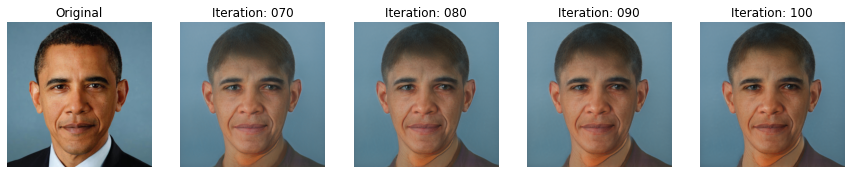

In [111]:
show_images_resuls(4)

Review the embedded latent codes

In [ ]:
with open('test.npy', 'rb') as f:
    for i in range(ITERATIONS//10):
        arr = np.load(f)
        print(arr)